# Predicting Song Success Based on Song Elements

**Harvard University**<br/>
**Fall 2022**<br/>
**Group Members**: Hongwen(Olivia) Song, Xiaoyuan(Sophy) Huang, Chao(Kenneth) Wang, Jinglun(Jerry) Gao

<hr style="height:2.4pt">

<a id="contents"></a>

### Import Libraries

In [32]:
import itertools
import math

import numpy as np
import numpy.linalg as la
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import cross_validate, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


## Notebook contents

- [**A description of the data**](#part1)

- [**Visualizations and captions**](#part2)



<a id="part1"></a>

## A description of the data

[Return to contents](#contents)

### Predicting song success

This is a dataset consisting of features for tracks fetched using Spotify's Web API. The tracks are labeled '1' or '0' ('Hit' or 'Flop') depending on some criteria of the author.

This dataset can be used to make a `classification model` that predicts whether a track would be a 'Hit' or not.

- **track**: The Name of the track.
  
- **artist**: The Name of the Artist.
  
- **uri**: The resource identifier for the track.

- **danceability**: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable. 

- **energy**: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. 

- **key**: The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C?/D?, 2 = D, and so on. **If no key was detected, the value is -1**.

- **loudness**: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db. 

- **mode**: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

- **speechiness**: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks. 

- **acousticness**: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic. 

- **instrumentalness**: Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0. 

- **liveness**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

- **valence**: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

- **tempo**: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration. 

- **duration_ms**:  The duration of the track in milliseconds.

- **time_signature**: An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).

- **chorus_hit**: This the the author's best estimate of when the chorus would start for the track. Its the timestamp of the start of the third section of the track. This feature was extracted from the data received by the API call for Audio Analysis of that particular track.

- **sections**: The number of sections the particular track has. This feature was extracted from the data received by the API call for Audio Analysis of that particular track.

- **target**: The target variable for the track. It can be either '0' or '1'. '1' implies that this song has featured in the weekly list (Issued by Billboards) of Hot-100 tracks in that decade at least once and is therefore a 'hit'. '0' Implies that the track is a 'flop'.

---

### Import data

In [2]:
df_00 = pd.read_csv('data/dataset-of-00s.csv')
df_10 = pd.read_csv('data/dataset-of-10s.csv')
df_60 = pd.read_csv('data/dataset-of-60s.csv')
df_70 = pd.read_csv('data/dataset-of-70s.csv')
df_80 = pd.read_csv('data/dataset-of-80s.csv')
df_90 = pd.read_csv('data/dataset-of-90s.csv')

In [3]:
df_00.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target
count,5872.000000,5872.000000,5872.000000,5872.000000,5872.000000,5872.000000,5872.000000,5872.000000,5872.000000,5872.000000,5872.000000,5.872000e+03,5872.000000,5872.000000,5872.000000,5872.000000
mean,0.542931,0.694511,5.276396,-7.449258,0.645095,0.092360,0.214374,0.150917,0.196141,0.482262,121.613018,2.581706e+05,3.913999,40.734295,11.056880,0.500000
std,0.190003,0.237792,3.564153,5.102543,0.478525,0.094997,0.296511,0.301452,0.161965,0.254567,30.179885,1.395341e+05,0.404280,20.245637,5.758186,0.500043
min,0.058800,0.000348,0.000000,-47.327000,0.000000,0.022400,0.000000,0.000000,0.019300,0.000000,46.755000,1.592000e+04,0.000000,0.000000,1.000000,0.000000
25%,0.416000,0.567000,2.000000,-8.315000,0.000000,0.036175,0.004553,0.000000,0.093700,0.278000,96.984000,2.068130e+05,4.000000,27.507507,9.000000,0.000000
50%,0.556000,0.744000,5.000000,-6.041500,1.000000,0.052700,0.060300,0.000022,0.131000,0.486000,119.999000,2.380065e+05,4.000000,36.037160,10.000000,0.500000
75%,0.681000,0.885000,8.000000,-4.562500,1.000000,0.107000,0.312000,0.047275,0.263000,0.687000,141.495250,2.791600e+05,4.000000,47.889570,12.000000,1.000000
max,0.986000,0.999000,11.000000,1.137000,1.000000,0.950000,0.996000,0.998000,0.987000,0.982000,213.233000,4.170227e+06,5.000000,262.615400,169.000000,1.000000


In [4]:
df_00.head()

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target
0,Lucky Man,Montgomery Gentry,spotify:track:4GiXBCUF7H6YfNQsnBRIzl,0.578,0.471,4,-7.270,1,0.0289,0.368000,0.00000,0.159,0.532,133.061,196707,4,30.88059,13,1
1,On The Hotline,Pretty Ricky,spotify:track:1zyqZONW985Cs4osz9wlsu,0.704,0.854,10,-5.477,0,0.1830,0.018500,0.00000,0.148,0.688,92.988,242587,4,41.51106,10,1
2,Clouds Of Dementia,Candlemass,spotify:track:6cHZf7RbxXCKwEkgAZT4mY,0.162,0.836,9,-3.009,1,0.0473,0.000111,0.00457,0.174,0.300,86.964,338893,4,65.32887,13,0
3,"Heavy Metal, Raise Hell!",Zwartketterij,spotify:track:2IjBPp2vMeX7LggzRN3iSX,0.188,0.994,4,-3.745,1,0.1660,0.000007,0.07840,0.192,0.333,148.440,255667,4,58.59528,9,0
4,I Got A Feelin',Billy Currington,spotify:track:1tF370eYXUcWwkIvaq3IGz,0.630,0.764,2,-4.353,1,0.0275,0.363000,0.00000,0.125,0.631,112.098,193760,4,22.62384,10,1


In [5]:
df_00.shape

(5872, 19)

**Q1.1** 

Do we want to make "decade" categorical or numarical?

In [6]:
df_00['decade'] = "00"
df_10['decade'] = "10"
df_60['decade'] = "60"
df_70['decade'] = "70"
df_80['decade'] = "80"
df_90['decade'] = "90"

### Data Concatenation

In [7]:
df_whole = pd.concat([df_60, df_70, df_80, df_90, df_00, df_10])

In [8]:
df_whole.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target
count,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,4.110600e+04,41106.000000,41106.000000,41106.000000,41106.000000
mean,0.539695,0.579545,5.213594,-10.221525,0.693354,0.072960,0.364197,0.154416,0.201535,0.542440,119.338249,2.348776e+05,3.893689,40.106041,10.475673,0.500000
std,0.177821,0.252628,3.534977,5.311626,0.461107,0.086112,0.338913,0.303530,0.172959,0.267329,29.098845,1.189674e+05,0.423073,19.005515,4.871850,0.500006
min,0.000000,0.000251,0.000000,-49.253000,0.000000,0.000000,0.000000,0.000000,0.013000,0.000000,0.000000,1.516800e+04,0.000000,0.000000,0.000000,0.000000
25%,0.420000,0.396000,2.000000,-12.816000,0.000000,0.033700,0.039400,0.000000,0.094000,0.330000,97.397000,1.729278e+05,4.000000,27.599792,8.000000,0.000000
50%,0.552000,0.601000,5.000000,-9.257000,1.000000,0.043400,0.258000,0.000120,0.132000,0.558000,117.565000,2.179070e+05,4.000000,35.850795,10.000000,0.500000
75%,0.669000,0.787000,8.000000,-6.374250,1.000000,0.069800,0.676000,0.061250,0.261000,0.768000,136.494000,2.667730e+05,4.000000,47.625615,12.000000,1.000000
max,0.988000,1.000000,11.000000,3.744000,1.000000,0.960000,0.996000,1.000000,0.999000,0.996000,241.423000,4.170227e+06,5.000000,433.182000,169.000000,1.000000


**Q1.2** 

Is there any missing values in key?

In [9]:
# If no key was detected, the value is -1
if sum(df_whole['key'] == -1) == 0:
    print("There is no missingness in key variable.")

There is no missingness in key variable.


In [10]:
df_whole.shape

(41106, 20)

In [11]:
df_whole.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41106 entries, 0 to 6397
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track             41106 non-null  object 
 1   artist            41106 non-null  object 
 2   uri               41106 non-null  object 
 3   danceability      41106 non-null  float64
 4   energy            41106 non-null  float64
 5   key               41106 non-null  int64  
 6   loudness          41106 non-null  float64
 7   mode              41106 non-null  int64  
 8   speechiness       41106 non-null  float64
 9   acousticness      41106 non-null  float64
 10  instrumentalness  41106 non-null  float64
 11  liveness          41106 non-null  float64
 12  valence           41106 non-null  float64
 13  tempo             41106 non-null  float64
 14  duration_ms       41106 non-null  int64  
 15  time_signature    41106 non-null  int64  
 16  chorus_hit        41106 non-null  float64

**Q1.3** 

Should we treat `speechiness` as a continuous variable or a categorical variable?

In [12]:
# Based on definition
speechiness_cat = pd.cut(df_whole['speechiness'], 
                        bins = [0, 0.33, 0.66, 1], 
                        labels = ["music and other non-speech-like tracks", "both music and speech", "entirely spoken"])

value_counts = speechiness_cat.value_counts()
for category, counts in zip(value_counts.index.values, value_counts.values):
    print(f"There is a total of {counts} observations for {category}.")

There is a total of 40144 observations for music and other non-speech-like tracks.
There is a total of 820 observations for both music and speech.
There is a total of 141 observations for entirely spoken.


The resulting categorical version of `speechiness` is highly unbalanced, based on the definition. Therefore, we do not transform it to categorical variable here.

List numarical columns. Remove `target` from the numerical columns.

In [13]:
num_cols = list(df_whole._get_numeric_data().columns)
num_cols.remove('target')
num_cols.remove('mode') # this is a categorical feature based on definition
num_cols.remove('key') # this is a categorical feature based on definition
num_cols

['danceability',
 'energy',
 'loudness',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'duration_ms',
 'time_signature',
 'chorus_hit',
 'sections']

List categorical columns

In [14]:
cat_cols = list(set(df_whole.columns) - set(num_cols))
cat_cols.remove('target')
cat_cols

['key', 'decade', 'mode', 'artist', 'uri', 'track']

Count frequency of category values

In [15]:
for col in cat_cols:
    print("----------------------------")
    print(col, df_whole[col].value_counts())

----------------------------
key 0     5130
7     4962
2     4619
9     4469
5     3790
4     3323
1     3278
11    2815
10    2728
8     2345
6     2217
3     1430
Name: key, dtype: int64
----------------------------
decade 60    8642
70    7766
80    6908
10    6398
00    5872
90    5520
Name: decade, dtype: int64
----------------------------
mode 1    28501
0    12605
Name: mode, dtype: int64
----------------------------
artist Traditional          207
Harry Belafonte      140
P. Susheela          130
Ennio Morricone      128
Jerry Goldsmith      124
                    ... 
Voyce                  1
Johnny Laboriel        1
Tribe 8                1
Albert Burbank         1
The Neighbourhood      1
Name: artist, Length: 11904, dtype: int64
----------------------------
uri spotify:track:0RgcOUQg4qYAEt9RIdf3oB    3
spotify:track:7tFiyTwD0nx5a1eklYtX2J    3
spotify:track:7vvRkLPIvfjjmCIqNxBuEZ    3
spotify:track:0hA8G8smCwi1h1nmxyRqT3    3
spotify:track:2fQ6sBFWaLv2Gxos4igHLy    3
     

### Missing values

In [16]:
# ! pip install missingno

In [17]:
import missingno as msno

<AxesSubplot:>

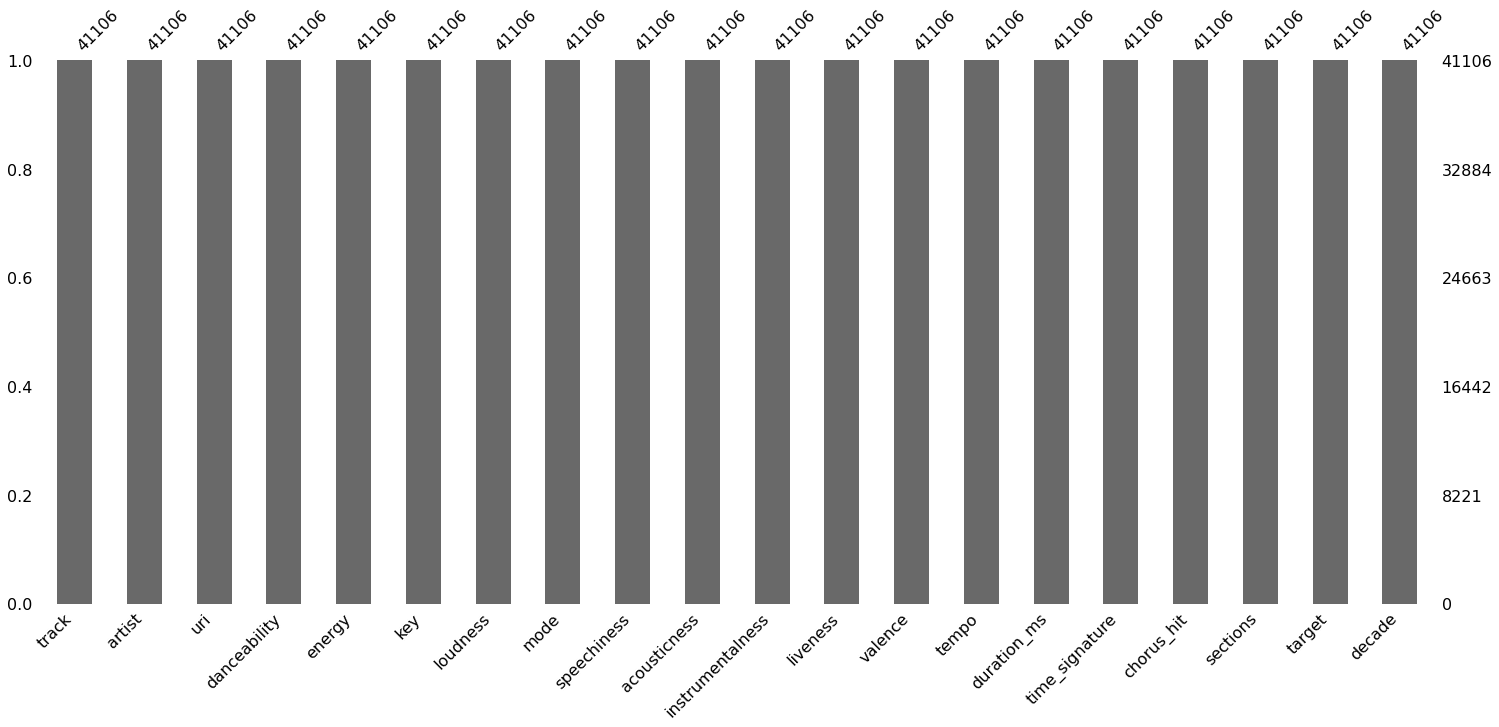

In [18]:
# Gives a bar chart of the missing values
msno.bar(df_whole)

<AxesSubplot:>

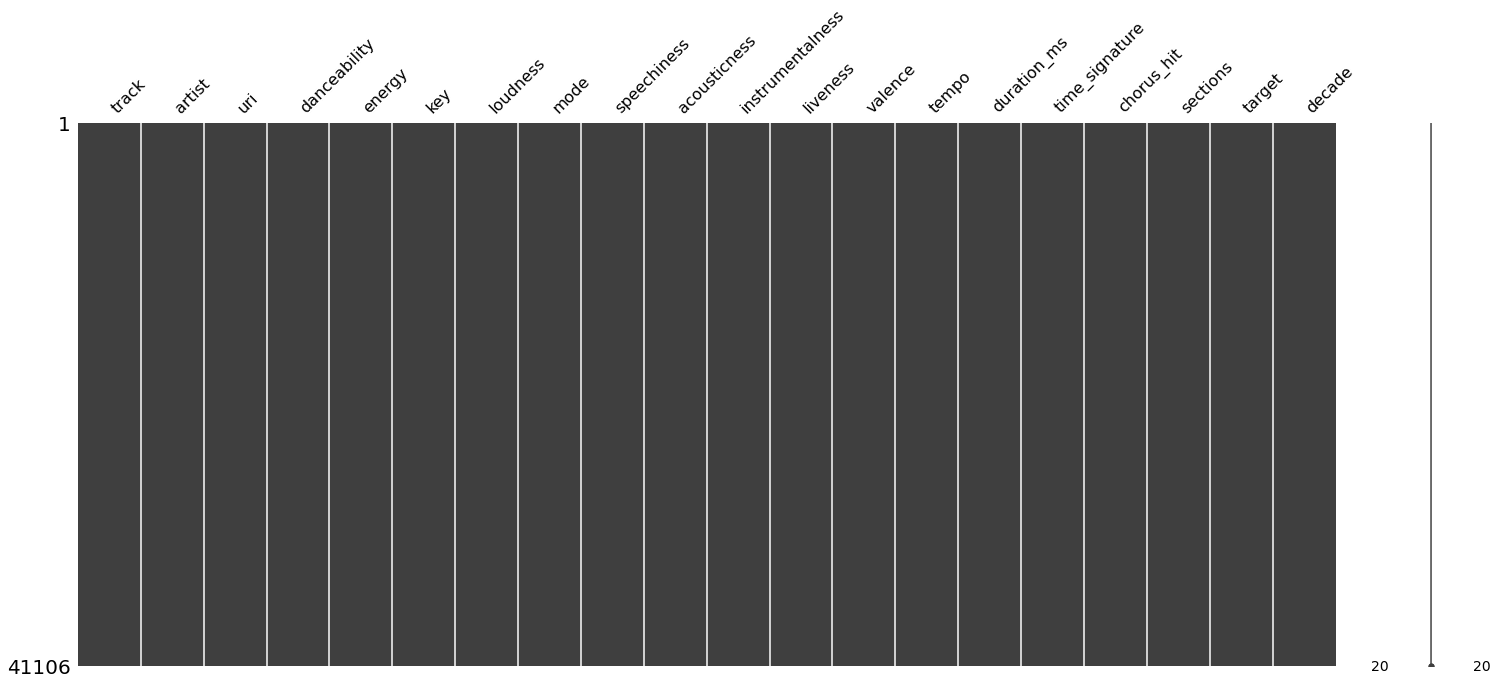

In [19]:
# Gives positional information of the missing values
msno.matrix(df_whole)

There is no missing values at all!

#### Data imbalanceness

In [20]:
df_whole.target.value_counts()

1    20553
0    20553
Name: target, dtype: int64

The target variable is perfectly balanced, so we will not worry about data data imbalanceness in the trainging process.

<a id="part2"></a>

## Visualizations and captions

[Return to contents](#contents)

Now we want to do some interesting exploratory data analysis (EDA) to explore the patterns in the dataset that can be helpful for song success prediction. However, before we do EDA, we want to have a holdout set of the data for the purpose of testing models' performance at the every end. We will only do EDA on training (and validation) data. 

In [21]:
np.random.seed(209)
df_train, df_test = train_test_split(
    df_whole,
    test_size=0.2,
    random_state=209,
    shuffle=True,
)

In [22]:
X_train = df_train.drop(columns=['target'])
y_train = df_train['target'] 
X_test = df_test.drop(columns=['target'])
y_test = df_test['target']

#### Explore how each of our predictors is associated with the target

In [42]:
predictor_ls = num_cols + ['mode', 'decade', 'key']
hist = num_cols
fig, axes = plt.subplots(4,4, sharey=False, figsize=(18,20))
plt.suptitle("Predictors' distribution by 'hit' status", x = 0.5, y = 1, fontsize = 25, color = [37/255, 169/255, 224/255])

for i, (ax, predictor) in enumerate(zip(axes.flat, predictor_ls)):
    if predictor in hist:
        ax.hist(
            X_train[predictor][(y_train == 1)],bins = 20, color = "dodgerblue", 
            density=True, alpha=0.5, label="hit")
        ax.hist(
            X_train[predictor][(y_train != 1)],bins = 20, color = "orange", 
            density=True, alpha=0.5, label="flop")
    else:
        hit_counts = X_train[predictor][(y_train == 1)].value_counts().sort_index()
        flop_counts = X_train[predictor][(y_train != 1)].value_counts().sort_index()

        ax.bar(hit_counts.index.values,
               hit_counts.values/np.sum(hit_counts.values),
               alpha=0.5, label="hit")
        ax.bar(flop_counts.index.values,
               flop_counts.values/np.sum(flop_counts.values),
               alpha=0.5, label="flop")
        ax.set_xticks(flop_counts.index)
    ax.set_xlabel(predictor, fontsize = 15)
    ax.set_ylabel('Percentage', fontsize = 15)
    # ax.grid(":", alpha=0.4)
    ax.legend(fontsize = 'large')
    
plt.tight_layout()
plt.show()

We don't include `artist`, `uri`, and `track` in the figure above because these three columns have too many categories that is hard to visualize in a small figure. 

In [24]:
def percentile25(x): return np.percentile(x, 25)
def percentile75(x): return np.percentile(x, 75)
print("Summary statistics of duration_ms:")
X_train.groupby(y_train)['duration_ms'].agg([np.mean, np.std, 'max', 'min', percentile25, percentile75])

Summary statistics of duration_ms:


,mean,std,max,min,percentile25,percentile75
target,,,,,,
0,243945.117597,153764.882906,4170227,15168,163333.0,282100.25
1,226272.188271,65680.230856,1367093,46893,181800.0,257993.25


There is a difference between hit and flop songs with respect to the `duration_ms` variable based on the plots and summary statistics. Therefore, we will pay more attension to this variable in later analysis.

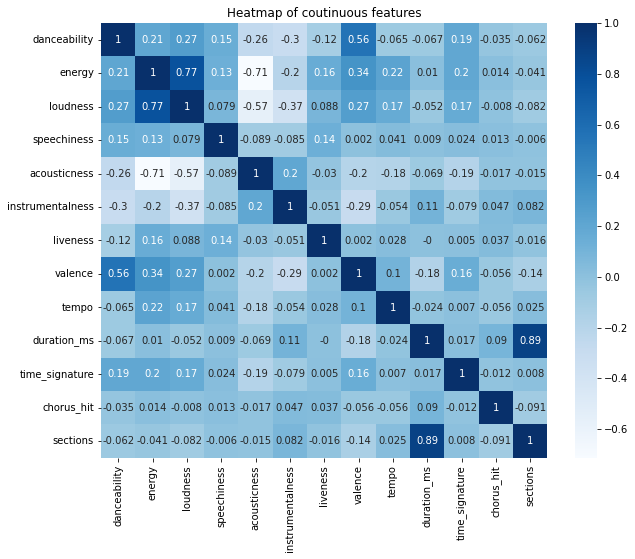

In [25]:
fig, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(np.round(X_train[num_cols].corr(), 3), cmap="Blues", annot=True)
ax.set_title("Heatmap of coutinuous features")
plt.show()

Based on the heatmap, we can see that some variables are highly correlated, such as sections and duration_ms, energy and loudness, and so on. Therefore, we will also consider dimension reduction method.

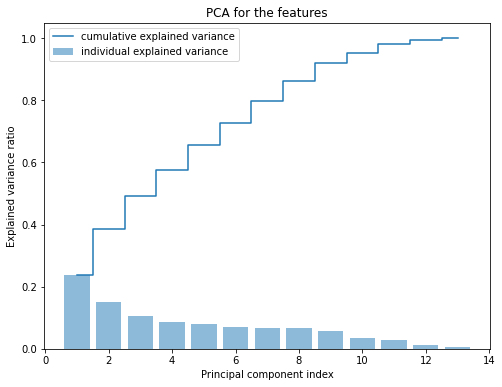

In [26]:
scaler = StandardScaler()
X_std = pd.DataFrame(scaler.fit_transform(X_train[num_cols]), columns = num_cols)

plt.figure(figsize = (8,6))
cov_mat = np.cov(X_std.values.T)
eigen_vals, eigen_vecs = la.eig(cov_mat)
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in
            sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
plt.bar(range(1,14), var_exp, alpha=0.5, align='center',
         label='individual explained variance')
plt.step(range(1,14), cum_var_exp, where='mid',
        label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.title("PCA for the features")
plt.legend(loc='best')
plt.show()

In [29]:
scalerX = StandardScaler().fit(X_train[num_cols])
X_train_std = pd.DataFrame(np.hstack((scalerX.transform(X_train[num_cols]), X_train[['mode', 'decade', 'key']])), columns = predictor_ls) 
X_test_std = pd.DataFrame(np.hstack((scalerX.transform(X_test[num_cols]), X_test[['mode', 'decade', 'key']])), columns = predictor_ls) 

In [39]:
# fit three basic classifier models
basic_classifier = ['logreg', 'Knn', 'decision tree']
estimator = [LogisticRegression(random_state = 123, max_iter = 1000),
             KNeighborsClassifier(),
             DecisionTreeClassifier(random_state = 123)]
for i in range(3):
    cv_score = cross_val_score(estimator[i], X_train_std, y_train, cv = 10)
    print('The accuracy score of 5-fold cross validation for {} is {} +/- {}'.format(basic_classifier[i],
                                                                                   np.round(np.mean(cv_score), 3),
                                                                                   np.round(np.std(cv_score), 3)))
    clf = estimator[i]
    clf.fit(X_train_std, y_train)
    print('The test accuracy score for {} is {}'.format(basic_classifier[i],
                                                         np.round(clf.score(X_test_std, y_test), 3)))
    print('----------------------------------------------------------------------')   

The accuracy score of 5-fold cross validation for logreg is 0.729 +/- 0.009
The test accuracy score for logreg is 0.731
----------------------------------------------------------------------
The accuracy score of 5-fold cross validation for Knn is 0.744 +/- 0.005
The test accuracy score for Knn is 0.744
----------------------------------------------------------------------
The accuracy score of 5-fold cross validation for decision tree is 0.714 +/- 0.01
The test accuracy score for decision tree is 0.714
----------------------------------------------------------------------


In [37]:
218 / (218 + 142), 35 / 40

(0.6055555555555555, 0.875)

In [38]:
41106, 218 + 142 + 40

(41106, 400)